In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
all_df = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'], test_df.loc[:,'MSSubClass':'SaleCondition']), axis=0,ignore_index=True)
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
quantitative = [f for f in all_df.columns if all_df.dtypes[f] != 'object']
qualitative = [f for f in all_df.columns if all_df.dtypes[f] == 'object']

In [4]:
missing = all_df.isnull().sum()
missing.sort_values(inplace=True,ascending=False)
missing = missing[missing > 0]

In [5]:
#dealing with missing data
all_df = all_df.drop(missing[missing>1].index,1)
# 对于missing 1 的我们到时候以平均数填充

In [6]:
all_df.isnull().sum()[all_df.isnull().sum()>0]

Exterior1st    1
Exterior2nd    1
BsmtFinSF1     1
BsmtFinSF2     1
BsmtUnfSF      1
TotalBsmtSF    1
Electrical     1
KitchenQual    1
GarageCars     1
GarageArea     1
SaleType       1
dtype: int64

In [7]:
logfeatures = ['GrLivArea','1stFlrSF','2ndFlrSF','TotalBsmtSF','LotArea','KitchenAbvGr','GarageArea']

In [8]:
for logfeature in logfeatures:
    all_df[logfeature] = np.log1p(all_df[logfeature].values)

In [9]:
all_df['HasBasement'] = all_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasGarage'] = all_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_df['Has2ndFloor'] = all_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasWoodDeck'] = all_df['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasPorch'] = all_df['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
all_df['HasPool'] = all_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_df['IsNew'] = all_df['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [10]:
quantitative = [f for f in all_df.columns if all_df.dtypes[f] != 'object']
qualitative = [f for f in all_df.columns if all_df.dtypes[f] == 'object']

In [11]:
all_dummy_df = pd.get_dummies(all_df)

In [12]:
all_dummy_df.isnull().sum().sum()

6

In [13]:
mean_cols = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [14]:
all_dummy_df.isnull().sum().sum()

0

In [15]:
X = all_dummy_df[quantitative]
std = StandardScaler()
s = std.fit_transform(X)

In [16]:
all_dummy_df[quantitative] = s

In [17]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [18]:
y_train = np.log(train_df.SalePrice)

In [19]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

y_train.values

array([12.24769432, 12.10901093, 12.31716669, ..., 12.49312952,
       11.86446223, 11.90158345])

In [20]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, dummy_train_df, y_train.values, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

alphas = np.logspace(-3, 2, 50)
cv_ridge = []
coefs = []
for alpha in alphas:
    model = Ridge(alpha = alpha)
    model.fit(dummy_train_df,y_train)
    cv_ridge.append(rmse_cv(model).mean())
    coefs.append(model.coef_)

Text(0, 0.5, 'rmse')

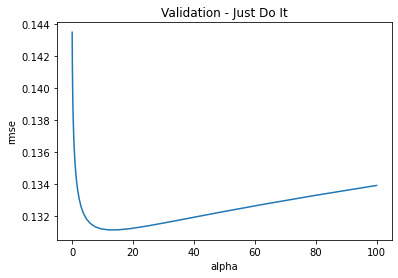

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
# plt.plot(alphas, cv_ridge)
# plt.title("Alpha vs CV Error")

Text(0, 0.5, 'rmse')

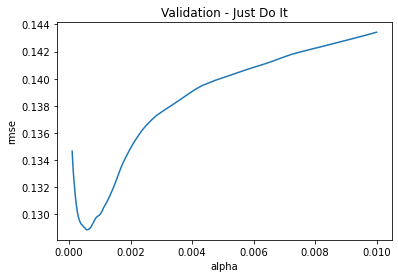

In [22]:
from sklearn.linear_model import Lasso,LassoCV

# alphas = np.logspace(-3, 2, 50)
# alphas = [1, 0.1, 0.001, 0.0005]
alphas = np.logspace(-4, -2, 100)
cv_lasso = []
coefs = []
for alpha in alphas:
    model = Lasso(alpha = alpha,max_iter=5000)
    model.fit(dummy_train_df,y_train)
    cv_lasso.append(rmse_cv(model).mean())
    coefs.append(model.coef_)
    
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
# plt.plot(alphas, cv_ridge)
# plt.title("Alpha vs CV Error")

In [23]:
print(cv_lasso.min(), cv_lasso.argmin())

0.12884368072165472 38


In [24]:
model = Lasso(alpha = 0.00058,max_iter=5000)
model.fit(dummy_train_df,y_train)

Lasso(alpha=0.00058, max_iter=5000)

In [25]:
Lasso(alpha=0.00058, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.00058, max_iter=5000)

In [26]:
coef = pd.Series(model.coef_, index = dummy_train_df.columns)

In [27]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 84 variables and eliminated the other 142 variables


In [28]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

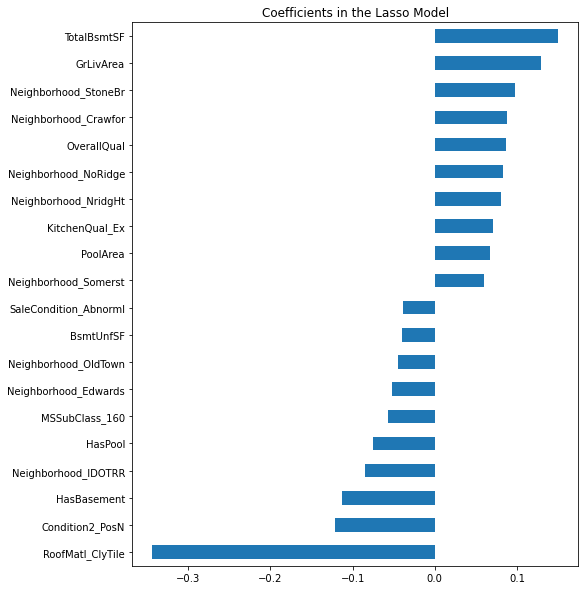

In [29]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")